In [4]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('./mytorch')

from mytorch import Tensor
from mytorch.model import Model
from mytorch.layer import Linear
from mytorch.loss import CategoricalCrossEntropy
from mytorch.optimizer import Adam

from mytorch.activation import relu, sigmoid, tanh, leaky_relu, softmax

# تنظیم سید برای تکرارپذیری نتایج
np.random.seed(42)

In [5]:
# پردازش داده‌ها
def get_processed_data(file_name="diabetes.csv"):
    data = pd.read_csv(file_name)
    
    # اصلاح مقادیر صفر نامعتبر
    target_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
    for c in target_cols:
        data[c] = data[c].replace(0, np.nan)
        data[c] = data[c].fillna(data[c].median())

    # جدا کردن ورودی و خروجی
    features = data.drop(columns=["Outcome"]).values.astype(np.float64)
    labels = data["Outcome"].values.astype(int)

    # نرمال‌سازی استاندارد (Z-Score)
    # فرمول: (X - Mean) / Std
    feat_mean = features.mean(axis=0)
    feat_std = features.std(axis=0) + 1e-8
    features = (features - feat_mean) / feat_std

    return features, labels


In [6]:
# تعریف مدل مقایسه‌گر
class ComparatorNet(Model):
    def __init__(self, act_name='relu'):
        super().__init__()
        self.act_name = act_name
        
        # تعریف لایه‌ها
        self.fc1 = Linear(8, 32, need_bias=True, mode="he")
        self.fc2 = Linear(32, 16, need_bias=True, mode="he")
        self.head = Linear(16, 2, need_bias=True, mode="xavier")
        
        # مپ کردن رشته به تابع واقعی
        self._act_map = {
            'relu': relu,
            'sigmoid': sigmoid,
            'tanh': tanh,
            'leaky_relu': leaky_relu
        }

    def _apply_activation(self, x):
        func = self._act_map.get(self.act_name, relu)
        return func(x)

    def forward(self, x: Tensor):
        # لایه اول + فعال‌ساز
        out = self._apply_activation(self.fc1(x))
        # لایه دوم + فعال‌ساز
        out = self._apply_activation(self.fc2(out))
        # لایه آخر (بدون سافت‌مکس در اینجا)
        logits = self.head(out)
        return logits

    def parameters(self):
        return [self.fc1, self.fc2, self.head]

In [7]:
# توابع آموزش و ارزیابی
def calc_acc(model, inputs, targets):
    """محاسبه دقت مدل"""
    t_in = Tensor(inputs)
    logits = model(t_in)
    probs = softmax(logits).data
    preds = np.argmax(probs, axis=1)
    acc = np.mean(preds == targets)
    return acc

def run_training_session(model, x_tr, y_tr, x_te, y_te, params):
    """اجرای حلقه آموزش و ثبت تاریخچه"""
    lr = params.get('lr', 0.001)
    epochs = params.get('epochs', 200)
    bs = params.get('batch_size', 32)
    
    optim = Adam(model.parameters(), learning_rate=lr)
    num_samples = len(x_tr)
    
    # دیکشنری برای ذخیره نتایج
    history = {
        'loss': [],
        'acc_train': [],
        'acc_test': [],
        'eval_epochs': []
    }
    
    for ep in range(1, epochs + 1):
        # شافل کردن دیتا
        indices = np.random.permutation(num_samples)
        x_shuffled, y_shuffled = x_tr[indices], y_tr[indices]
        
        epoch_loss = 0.0
        correct = 0
        batches = 0
        
        for i in range(0, num_samples, bs):
            # ساخت مینی‌بچ
            xb = Tensor(x_shuffled[i:i+bs], requires_grad=True)
            yb = Tensor(y_shuffled[i:i+bs])
            
            # انتشار جلو و عقب
            logits = model(xb)
            probs = softmax(logits)
            loss_val = CategoricalCrossEntropy(probs, yb)
            
            optim.zero_grad()
            loss_val.backward()
            optim.step()
            
            # آمار
            epoch_loss += loss_val.data
            cls_preds = np.argmax(probs.data, axis=1)
            correct += np.sum(cls_preds == y_shuffled[i:i+bs])
            batches += 1
            
        # میانگین‌گیری ایپاک
        avg_loss = epoch_loss / batches
        train_acc = correct / num_samples
        
        history['loss'].append(avg_loss)
        history['acc_train'].append(train_acc)
        
        # تست در بازه‌های مشخص
        if ep % 10 == 0 or ep == 1 or ep == epochs:
            test_acc = calc_acc(model, x_te, y_te)
            history['acc_test'].append(test_acc)
            history['eval_epochs'].append(ep)
        
        # نمایش وضعیت (هر 20 دور)
        if ep % 20 == 0:
            last_test = history['acc_test'][-1] if history['acc_test'] else 0
            print(f"   Epoch {ep:3d} | Loss: {avg_loss:.4f} | Tr Acc: {train_acc:.2%} | Te Acc: {last_test:.2%}")
            
    return history

In [8]:
# توابع ترسیم و گزارش
def draw_activation_shapes():
    """رسم شکل توابع فعال‌ساز جهت آشنایی"""
    z = np.linspace(-3, 3, 100)
    fig, axs = plt.subplots(1, 4, figsize=(16, 3))
    
    funcs = [
        ('Sigmoid', 1 / (1 + np.exp(-z))),
        ('Tanh', np.tanh(z)),
        ('ReLU', np.maximum(0, z)),
        ('Leaky ReLU', np.where(z > 0, z, 0.01 * z))
    ]
    
    colors = ['crimson', 'royalblue', 'forestgreen', 'darkorange']
    
    for i, (name, y_vals) in enumerate(funcs):
        axs[i].plot(z, y_vals, color=colors[i], lw=2)
        axs[i].set_title(name)
        axs[i].grid(True, alpha=0.3)
        axs[i].axhline(0, color='k', lw=0.5)
        axs[i].axvline(0, color='k', lw=0.5)
        
    plt.tight_layout()
    plt.show()

def visualize_benchmark(results_map):
    """رسم نمودارهای مقایسه‌ای جامع"""
    act_list = list(results_map.keys())
    colors = ['red', 'blue', 'green', 'orange']
    
    fig = plt.figure(figsize=(18, 10))
    
    # 1. منحنی‌های یادگیری (Loss)
    plt.subplot(2, 3, 1)
    for i, act in enumerate(act_list):
        plt.plot(results_map[act]['hist']['loss'], label=act, color=colors[i])
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. منحنی‌های دقت آموزش
    plt.subplot(2, 3, 2)
    for i, act in enumerate(act_list):
        plt.plot(results_map[act]['hist']['acc_train'], label=act, color=colors[i])
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.grid(True, alpha=0.3)

    # 3. منحنی‌های دقت تست
    plt.subplot(2, 3, 3)
    for i, act in enumerate(act_list):
        eps = results_map[act]['hist']['eval_epochs']
        accs = results_map[act]['hist']['acc_test']
        plt.plot(eps, accs, 'o-', label=act, color=colors[i], markersize=4)
    plt.axhline(0.60, color='k', ls='--', alpha=0.5, label='Goal (60%)')
    plt.title('Test Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. نمودار میله‌ای نهایی
    plt.subplot(2, 1, 2)
    final_tr = [results_map[a]['final_tr'] for a in act_list]
    final_te = [results_map[a]['final_te'] for a in act_list]
    
    x = np.arange(len(act_list))
    w = 0.35
    
    plt.bar(x - w/2, final_tr, w, label='Train Acc', color='skyblue')
    plt.bar(x + w/2, final_te, w, label='Test Acc', color='salmon')
    
    plt.axhline(0.60, color='red', ls=':', lw=2)
    plt.axhline(0.70, color='blue', ls=':', lw=2)
    
    plt.xticks(x, act_list)
    plt.ylabel('Accuracy')
    plt.title('Final Performance Comparison')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def print_summary_table(results_map):
    """چاپ جدول خلاصه نتایج"""
    print("\n" + "="*60)
    print(f"{'Activation':<15} | {'Train Acc':<10} | {'Test Acc':<10} | {'Status'}")
    print("-" * 60)
    
    for act, res in results_map.items():
        tr_acc = res['final_tr']
        te_acc = res['final_te']
        status = "✅ Pass" if te_acc >= 0.60 else "⚠️ Low Acc"
        print(f"{act:<15} | {tr_acc:.4f}     | {te_acc:.4f}     | {status}")
    print("="*60 + "\n")

>>> Starting Phase 3: Activation Function Benchmarking

Data Loaded: 768 samples (Train: 614, Test: 154)
Generating activation plots...


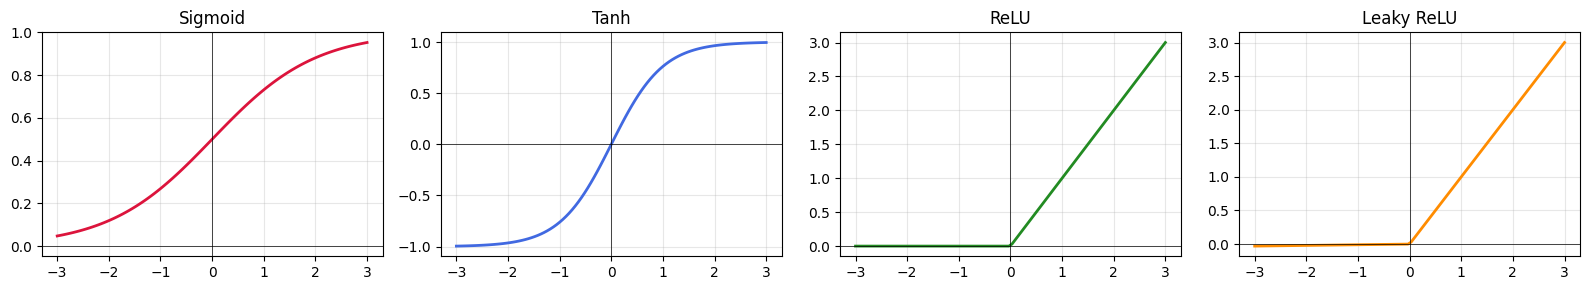


Training with [SIGMOID]...
   Epoch  20 | Loss: 0.4722 | Tr Acc: 76.22% | Te Acc: 73.38%
   Epoch  40 | Loss: 0.4588 | Tr Acc: 78.01% | Te Acc: 75.32%
   Epoch  60 | Loss: 0.4412 | Tr Acc: 78.99% | Te Acc: 77.27%
   Epoch  80 | Loss: 0.4532 | Tr Acc: 79.48% | Te Acc: 76.62%
   Epoch 100 | Loss: 0.4377 | Tr Acc: 79.32% | Te Acc: 77.27%
   Epoch 120 | Loss: 0.4261 | Tr Acc: 80.29% | Te Acc: 74.68%
   Epoch 140 | Loss: 0.4243 | Tr Acc: 79.97% | Te Acc: 75.32%
   Epoch 160 | Loss: 0.4217 | Tr Acc: 79.97% | Te Acc: 74.68%
   Epoch 180 | Loss: 0.4187 | Tr Acc: 81.11% | Te Acc: 74.68%
   Epoch 200 | Loss: 0.4146 | Tr Acc: 80.46% | Te Acc: 75.32%

Training with [TANH]...
   Epoch  20 | Loss: 0.4514 | Tr Acc: 80.78% | Te Acc: 77.27%
   Epoch  40 | Loss: 0.3957 | Tr Acc: 81.92% | Te Acc: 79.22%
   Epoch  60 | Loss: 0.3805 | Tr Acc: 83.88% | Te Acc: 79.22%
   Epoch  80 | Loss: 0.3597 | Tr Acc: 85.34% | Te Acc: 79.22%
   Epoch 100 | Loss: 0.3200 | Tr Acc: 86.32% | Te Acc: 77.27%
   Epoch 120 | Lo

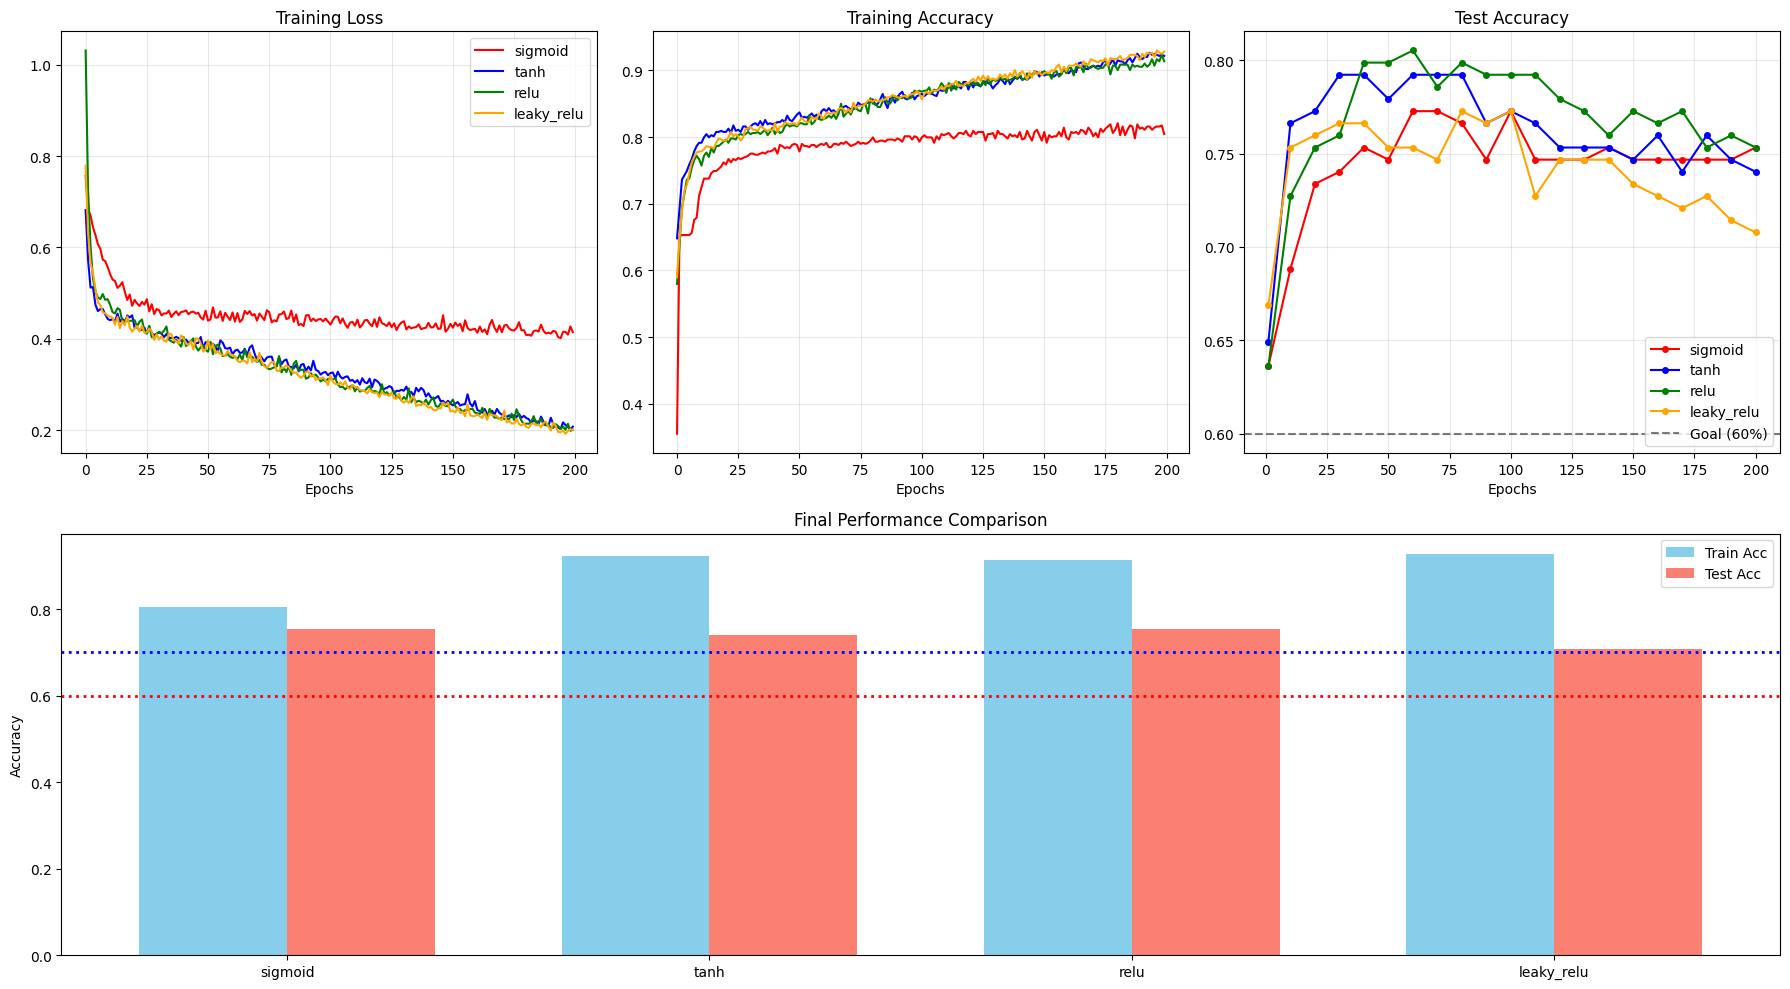

In [9]:
# (Main)
def main():
    print(">>> Starting Phase 3: Activation Function Benchmarking\n")
    
    # 1. آماده‌سازی داده
    X, y = get_processed_data("diabetes.csv")
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    
    print(f"Data Loaded: {len(X)} samples (Train: {len(X_train)}, Test: {len(X_test)})")
    
    # 2. رسم شکل توابع برای گزارش
    print("Generating activation plots...")
    draw_activation_shapes()
    
    # 3. حلقه مقایسه
    activations = ['sigmoid', 'tanh', 'relu', 'leaky_relu']
    benchmark_results = {}
    
    train_config = {'lr': 0.001, 'epochs': 200, 'batch_size': 32}
    
    for act in activations:
        print(f"\nTraining with [{act.upper()}]...")
        net = ComparatorNet(act_name=act)
        
        hist = run_training_session(net, X_train, y_train, X_test, y_test, train_config)
        
        benchmark_results[act] = {
            'hist': hist,
            'final_tr': hist['acc_train'][-1],
            'final_te': hist['acc_test'][-1]
        }
        
    # 4. نمایش نتایج
    print_summary_table(benchmark_results)
    visualize_benchmark(benchmark_results)

if __name__ == "__main__":
    main()